In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

## 一、PyTorch基本操作考察

1. 用Tensor初始化一个1x3 的矩阵M和一个2x1的矩阵N，对两矩阵进行减法操作（要求实现三种不同的形式），给出结果并分析三种方式的不同（如果出现报错，分析报错的原因），同时需要指出在计算过程中发生了什么

In [ ]:
M = torch.zeros((1, 3))
N = torch.ones((2, 1))

In [2]:
t = M - N
t

tensor([[-1., -1., -1.],
        [-1., -1., -1.]])

In [4]:
t = torch.sub(M, N)
t

tensor([[-1., -1., -1.],
        [-1., -1., -1.]])

In [6]:
t = torch.add(M, -N)
t

tensor([[-1., -1., -1.],
        [-1., -1., -1.]])

2. ①利用Tensor创建两个大小分别3x2 和4x2的随机数矩阵P和Q，要求服从均值为0，标准差0.01为的正态分布；②对第二步得到的矩阵Q进行形状变换得到Q的转置QT；③对上述得到的矩阵P和矩阵QT求矩阵相乘

In [7]:
P = torch.zeros((3, 2))
Q = torch.zeros((4, 2))

P = torch.normal(P, 0.01)
Q = torch.normal(Q, 0.01)

In [8]:
P

tensor([[-0.0069, -0.0179],
        [ 0.0086,  0.0057],
        [-0.0082, -0.0004]])

In [9]:
Q

tensor([[-0.0035, -0.0010],
        [ 0.0042, -0.0114],
        [-0.0040,  0.0021],
        [-0.0039,  0.0024]])

In [12]:
QT = Q.T
QT

tensor([[-0.0035,  0.0042, -0.0040, -0.0039],
        [-0.0010, -0.0114,  0.0021,  0.0024]])

In [13]:
torch.mm(P, QT)

tensor([[ 4.2152e-05,  1.7581e-04, -1.0506e-05, -1.6401e-05],
        [-3.6047e-05, -2.9239e-05, -2.2230e-05, -1.9844e-05],
        [ 2.9159e-05, -3.0390e-05,  3.1911e-05,  3.1166e-05]])

3. 给定公式 $y_3 = y_1+y_2=x^2+x^3$，且$x=1$。利用学习所得到的Tensor的相关知识，求$y_3$对$x$的梯度。要求在计算过程中，在计算$x^3$时中断梯度的追踪，观察结果并进行原因分析

In [21]:
x = torch.tensor(1.0, requires_grad=True)
x

tensor(1., requires_grad=True)

In [24]:
y1 = torch.pow(x, 2)
y2 = torch.pow(x, 3)
y3 = torch.add(y1, y2)

In [27]:
y3.backward()

In [28]:
x.grad

tensor(5.)

若在计算 $x^3$ 时中断梯度的跟踪

In [30]:
x = torch.tensor(1.0, requires_grad=True)
y1 = torch.pow(x, 2)
with torch.no_grad():
    y2 = torch.pow(x, 3)
y3 = torch.add(y1, y2)
y3.backward()
x.grad

tensor(2.)

原因是：
![](assets/1-1.png)

## 二、动手实现 Logistic 回归

1. 要求动手从0实现logistic回归（只借助Tensor和Numpy相关的库）在人工构造的数据集上进行训练和测试，并从loss以及训练集上的准确率等多个角度对结果进行分析(可借助nn.BCELoss或nn.BCEWithLogitsLoss作为损失函数，从零实现二元交叉熵为选作）

逻辑回归可以看作是一个前馈神经网络，但这个网络非常简单：没有隐藏层，输出层使用 logistic 函数 作为激活函数，并采用 交叉熵损失函数 来训练。

In [41]:
import matplotlib.pyplot as plt

def draw_loss(input_loss):
    x = np.linspace(0, len(input_loss)-1, len(input_loss))
    plt.plot(x, input_loss, label="Train Loss", linewidth=1.5)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

In [42]:
# 构造数据集

n_data = torch.ones(50, 2) # 数据的基本形态
x1 = torch.normal(2 * n_data, 1) # shape=(50, 2)
y1 = torch.zeros((50, 1)) # 类型0 shape=(50, 1)
x2 = torch.normal(-2 * n_data, 1) # shape=(50, 2)
y2 = torch.ones((50, 1)) # 类型1 shape=(50, 1)

# 注意 x, y 数据的数据形式一定要像下面一样 (torch.cat 是合并数据)
my_values = torch.cat((x1, x2), 0).type(torch.FloatTensor)
my_labels = torch.cat((y1, y2), 0).type(torch.FloatTensor)

In [43]:
import random

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield features.index_select(0, j), labels.index_select(0, j)

In [44]:
def Net(X: torch.Tensor, w: torch.Tensor, b: torch.Tensor):
    Z = None
    A = None
    
    # Linear Part
    Z = torch.mm(X, w) + b
    # Logistic Part
    A = torch.div(1, torch.add(1, torch.exp(torch.negative(Z))))
    return A

In [45]:
def bce(y_hat, y, epsilon=1e-12):
    y_hat = torch.clamp(y_hat, epsilon, 1. - epsilon)  # Clamp y_hat to avoid log(0)
    return -torch.sum(torch.mul(y, torch.log(y_hat)) + torch.mul(1-y, torch.log(1-y_hat))) / y_hat.size()[0]

In [46]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

In [47]:
def clear_grad(params):
    for param in params:
        param.grad.data.zero_()

In [48]:
epochs = 1000
batch_size = 256
net = Net
loss = bce
lr = 0.5

# 初始化参数
w = torch.normal(0, 0.01, (2, 1))
b = torch.zeros((1, 1))

# 设置参数 requires grad
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

all_train_loss = []
for epoch in range(epochs):
    for X, y in data_iter(batch_size, my_values, my_labels):
        y_hat = net(X, w, b)
        l = loss(y_hat, y)
        l.backward()
        sgd([w, b], lr, batch_size)
        clear_grad([w, b])
    train_loss = loss(net(my_values, w, b), my_labels).mean().item()
    all_train_loss.append(train_loss)
    print(f"Epoch: {epoch+1} / {epochs}, loss: {train_loss}")
    
print(w, b)

Epoch: 1 / 1000, loss: 0.6939721703529358
Epoch: 2 / 1000, loss: 0.6895520687103271
Epoch: 3 / 1000, loss: 0.6851757168769836
Epoch: 4 / 1000, loss: 0.6808424592018127
Epoch: 5 / 1000, loss: 0.6765519976615906
Epoch: 6 / 1000, loss: 0.6723039746284485
Epoch: 7 / 1000, loss: 0.6680979132652283
Epoch: 8 / 1000, loss: 0.6639333963394165
Epoch: 9 / 1000, loss: 0.6598098874092102
Epoch: 10 / 1000, loss: 0.6557270884513855
Epoch: 11 / 1000, loss: 0.6516845226287842
Epoch: 12 / 1000, loss: 0.6476818323135376
Epoch: 13 / 1000, loss: 0.6437184810638428
Epoch: 14 / 1000, loss: 0.639794111251831
Epoch: 15 / 1000, loss: 0.6359083652496338
Epoch: 16 / 1000, loss: 0.6320608258247375
Epoch: 17 / 1000, loss: 0.6282510161399841
Epoch: 18 / 1000, loss: 0.6244786381721497
Epoch: 19 / 1000, loss: 0.6207431554794312
Epoch: 20 / 1000, loss: 0.6170443892478943
Epoch: 21 / 1000, loss: 0.6133816838264465
Epoch: 22 / 1000, loss: 0.6097548007965088
Epoch: 23 / 1000, loss: 0.6061633229255676
Epoch: 24 / 1000, los

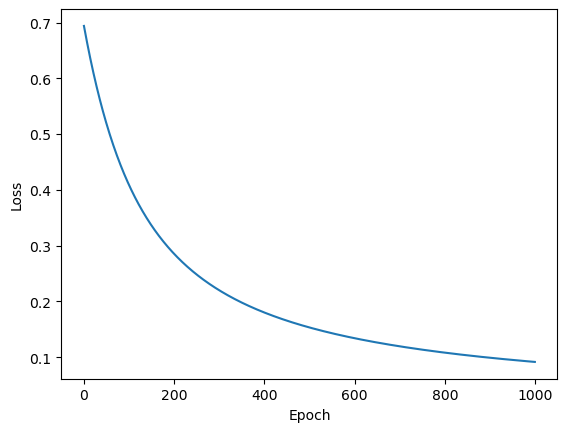

In [49]:
draw_loss(all_train_loss)

2. 利用 torch.nn 实现 logistic 回归在人工构造的数据集上进行训练和测试，并对结果进行分析，并从loss以及训练集上的准确率等多个角度对结果进行分析

In [50]:
import matplotlib.pyplot as plt

def draw_loss(input_loss):
    x = np.linspace(0, len(input_loss)-1, len(input_loss))
    plt.plot(x, input_loss, label="Train Loss", linewidth=1.5)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

In [51]:
from torch.utils import data as Data

In [52]:
# 构造数据集

n_data = torch.ones(50, 2)  # 数据的基本形态
x1 = torch.normal(2 * n_data, 1)  # shape=(50, 2)
y1 = torch.zeros((50, 1))  # 类型0 shape=(50, 1)
x2 = torch.normal(-2 * n_data, 1)  # shape=(50, 2)
y2 = torch.ones((50, 1))  # 类型1 shape=(50, 1)

# 注意 x, y 数据的数据形式一定要像下面一样 (torch.cat 是合并数据)
my_values = torch.cat((x1, x2), 0).type(torch.FloatTensor)
my_labels = torch.cat((y1, y2), 0).type(torch.FloatTensor)

In [53]:
# 数据读取
batch_size = 256
dataset = Data.TensorDataset(my_values, my_labels)
data_iter_new = Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [54]:
class LogisticNet(nn.Module):
    def __init__(self, n_feature):
        super(LogisticNet, self).__init__()
        self.model = nn.Linear(n_feature, 1)
        
        torch.nn.init.normal_(self.model.weight, mean=0, std=0.01)
        torch.nn.init.constant_(self.model.bias, val=0)

    def forward(self, x):
        return torch.sigmoid(self.model(x))

In [55]:
net = LogisticNet(2)
epochs = 1000
lr = 0.5
loss = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

all_train_loss = []
for epoch in range(epochs):
    for X, y in data_iter_new:
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    all_train_loss.append(l.item())
    print(f"Epoch: {epoch+1} / {epochs}, loss: {l.item()}")

Epoch: 1 / 1000, loss: 0.685330331325531
Epoch: 2 / 1000, loss: 0.17269235849380493
Epoch: 3 / 1000, loss: 0.12514549493789673
Epoch: 4 / 1000, loss: 0.10146491229534149
Epoch: 5 / 1000, loss: 0.08676838129758835
Epoch: 6 / 1000, loss: 0.07657510787248611
Epoch: 7 / 1000, loss: 0.06900428980588913
Epoch: 8 / 1000, loss: 0.06311226636171341
Epoch: 9 / 1000, loss: 0.05836799740791321
Epoch: 10 / 1000, loss: 0.05444755032658577
Epoch: 11 / 1000, loss: 0.05114101991057396
Epoch: 12 / 1000, loss: 0.04830583557486534
Epoch: 13 / 1000, loss: 0.045841485261917114
Epoch: 14 / 1000, loss: 0.043674807995557785
Epoch: 15 / 1000, loss: 0.041751276701688766
Epoch: 16 / 1000, loss: 0.04002922400832176
Epoch: 17 / 1000, loss: 0.03847629949450493
Epoch: 18 / 1000, loss: 0.03706691414117813
Epoch: 19 / 1000, loss: 0.035780537873506546
Epoch: 20 / 1000, loss: 0.034600529819726944
Epoch: 21 / 1000, loss: 0.033513203263282776
Epoch: 22 / 1000, loss: 0.03250720351934433
Epoch: 23 / 1000, loss: 0.03157301247

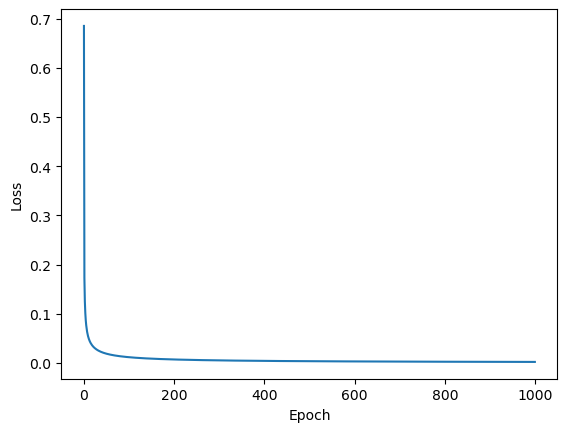

In [56]:
draw_loss(all_train_loss)

## 三、动手实现 softmax 回归

1. 要求动手从0实现 softmax 回归（只借助Tensor和Numpy相关的库）在Fashion-MNIST数据集上进行训练和测试，并从loss、训练集以及测试集上的准确率等多个角度对结果进行分析（要求从零实现交叉熵损失函数）